In [1]:
import pysam
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
from itertools import groupby

sns.set(style='whitegrid', font='serif')

# imports from other HWs
import nbimporter

from HW2 import plot_genome_coverage, get_full_read_sequences, _update_snps_with_read, _print_table_from_dict

Importing Jupyter notebook from HW2.ipynb


In [2]:
# This part of the part is a little bit rewritten because for better performance we need only one data pass

def print_stats(sam_file):
    sam = pysam.AlignmentFile(sam_file, "r")
    snps = Counter()
    all_bases_count = 0
    indel_lengths = []

    for i, read in enumerate(sam):
        if read.is_unmapped or read.is_supplementary or not read.has_tag('MD'): continue

        # getting usable matched sequences
        try:
            full_ref_seq, full_read_seq = get_full_read_sequences(read, with_qualities=False)
        except TypeError:
            # for some reason few reads do not have sequence and then TypeError is thown from pysam
            continue
        
        assert len(full_ref_seq) == len(full_read_seq)
              
        # Frequency of replacement / insertion / deletion table
        _update_snps_with_read(snps, full_ref_seq, full_read_seq)

        # All bases count
        all_bases_count += len(full_ref_seq)
        
        # indel length distribution
        indel_lengths += [len(list(g)) for n, g in groupby(full_read_seq) if n == '_']
    
    
    plt.rcParams['figure.dpi'] = 90
    g = sns.violinplot(indel_lengths).set_xscale("log")
    plt.title('Indel length distribution (vionilplot)')
    plt.xlabel('Indel length')
    plt.show()
    
    print('Indel length distribution')
    print(f'min={np.min(indel_lengths)}, Q1={np.percentile(indel_lengths, 25)}, median={np.percentile(indel_lengths, 50)}, mean={np.mean(indel_lengths)}, Q3={np.percentile(indel_lengths, 75)}, max={np.max(indel_lengths)}')
    print()

    _print_table_from_dict(snps, values=['A', 'C', 'G', 'T', '_'])

    print()
    print('Error rate (including indels and duplications):', sum(snps.values()) / all_bases_count * 100, '%')

## Датасет №1: pacbio_40x.fq.gz

In [3]:
# -H use homopolymer-compressed k-mer (preferrable for PacBio)
!minimap2 --MD -H -a -t 4 data/3/reference.fasta data/3/pacbio_40x.fq.gz > data/3/pacbio_alignment.sam

[M::mm_idx_gen::0.373*1.32] collected minimizers
[M::mm_idx_gen::0.401*1.44] sorted minimizers
[M::main::0.402*1.44] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.421*1.41] mid_occ = 12
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.442*1.37] distinct minimizers: 513422 (82.88% are singletons); average occurrences: 1.235; average spacing: 7.318
[M::worker_pipeline::107.655*2.24] mapped 41447 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 --MD -H -a -t 4 data/3/reference.fasta data/3/pacbio_40x.fq.gz
[M::main] Real time: 107.723 sec; CPU: 241.528 sec; Peak RSS: 1.477 GB


In [4]:
!samtools flagstat data/3/pacbio_alignment.sam

52242 + 0 in total (QC-passed reads + QC-failed reads)
1701 + 0 secondary
9094 + 0 supplementary
0 + 0 duplicates
51645 + 0 mapped (98.86% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### Покрытие

Mean genome coverage: 40.85341668463031
% of covered genome: 100.0


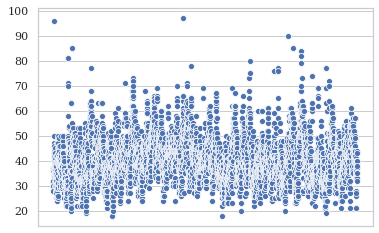

In [5]:
plot_genome_coverage('data/3/pacbio_alignment.sam')

### Статистики

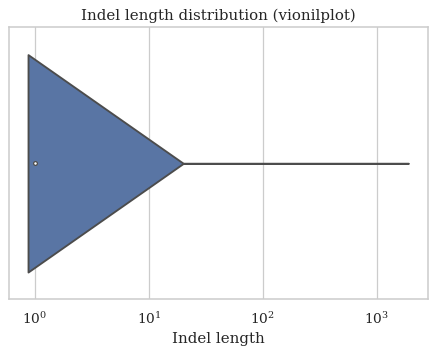

Indel length distribution
min=1, Q1=1.0, median=1.0, mean=1.1989585575615782, Q3=1.0, max=1900

                   A                 C                 G                 T                 _ 
A                  -            344171            299288            279530           1407418
C             447907                 -            404479            315654           2022733
G             315202            405602                 -            441334           2011319
T             278642            300801            350115                 -           1402281
_           10845529          11288085          11331436          10854484                 -

Error rate (including indels and duplications): 24.66089581193581 %


In [6]:
print_stats('data/3/pacbio_alignment.sam')

## Датасет №2: ONT_2D.fastq.gz

In [7]:
!minimap2 --MD -a -t 4 data/3/reference.fasta data/3/ONT_2D.fastq.gz > data/3/ONT_alignment.sam

[M::mm_idx_gen::0.227*1.13] collected minimizers
[M::mm_idx_gen::0.271*1.40] sorted minimizers
[M::main::0.271*1.40] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.288*1.37] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.301*1.35] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352
[M::worker_pipeline::35.331*2.50] mapped 30810 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 --MD -a -t 4 data/3/reference.fasta data/3/ONT_2D.fastq.gz
[M::main] Real time: 35.362 sec; CPU: 88.477 sec; Peak RSS: 1.083 GB


In [8]:
!samtools flagstat data/3/ONT_alignment.sam

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### Покрытие

Mean genome coverage: 28.33196809657254
% of covered genome: 100.0


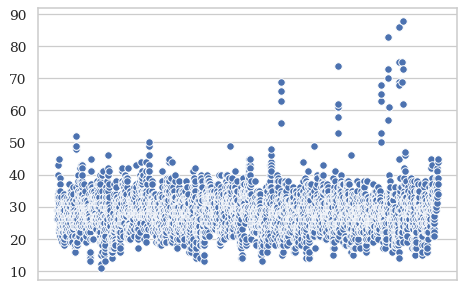

In [9]:
plot_genome_coverage('data/3/ONT_alignment.sam')

### Статистики

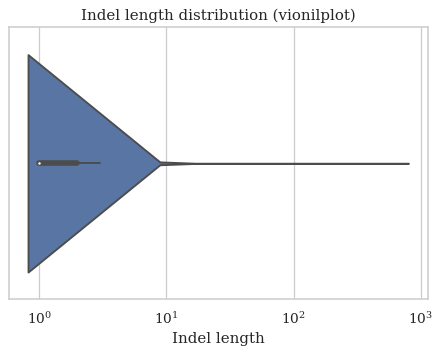

Indel length distribution
min=1, Q1=1.0, median=1.0, mean=1.877250341541831, Q3=2.0, max=798

                   A                 C                 G                 T                 _ 
A                  -            111793            366343            104257           1602578
C             135983                 -             84140            338748           1532362
G             317694             90403                 -            125395           1553759
T             106681            370667            110296                 -           1599458
_            1032775            924616            944799           1027283                 -

Error rate (including indels and duplications): 9.340746585069054 %


In [10]:
print_stats('data/3/ONT_alignment.sam')

## Сравнение результатов

У PacBio средние количество ошибок оказалось значительно выше (24.7 % против 9.3 %).

При этом у PacBio бОльшая часть ошибок — это вставки (в 7-10 раз больше, чем остальных ошибок вместе взятых), что выглядит весьма удивительно.
Это может быть связно с тем, что риды были плохо картированы и имеют большие soft slipping концы, или с особенностями технологии.
Наименьшую долю ошибок занимают замены.

У Nanopore же распределение между вставками и удалениями более равномерное и они имеют один порядок.
При этом замен нуклеотидов общей сложности в 2-3 раза меньше чем вставок или удалений.

Большая часть инделов в обоих случаях имеют длину 1.
Однако третий квартиль у Pacbio равен 1, а у Nanopore 2, а также среднее значение длины индела немного выше в нанопор.
Что говорит о том, что у нанопор инделы в среднем незначительно длинее.